In [1]:
import pandas as pd
import numpy as np
import sklearn

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
def information(rtd):
    info = pd.DataFrame({'Column': rtd.columns})
    info['unique'] = [len(rtd[c].unique()) for c in rtd.columns]
    info['type'] = [rtd[c].dtype for c in rtd.columns]
    info['isNull'] = [sum(rtd[c].isnull()) for c in rtd.columns]
    return info.set_index('Column')

In [4]:
loc_train = 'raw_data\\train.csv'
loc_test = 'raw_data\\test.csv'

target = 'SalePrice'
learning = 'Regression' # 'Regression' or 'Classification'
evaluation = 'neg_mean_squared_log_error'

raw_train_data = pd.read_csv(loc_train)
y = raw_train_data[target]
raw_train_data = raw_train_data.drop(target, axis=1)
raw_test_data = pd.read_csv(loc_test)
raw_train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
info = information(raw_train_data)

In [6]:
info[info.isNull>0]

,unique,type,isNull
Column,,,
LotFrontage,111,float64,259
Alley,3,object,1369
MasVnrType,5,object,8
MasVnrArea,328,float64,8
BsmtQual,5,object,37
BsmtCond,5,object,37
BsmtExposure,5,object,38
BsmtFinType1,7,object,37
BsmtFinType2,7,object,38


In [7]:
for col in info[(info.type == 'object') & (info.isNull>0)].index:
    print (col, '\t', raw_train_data[col].unique())

Alley 	 [nan 'Grvl' 'Pave']
MasVnrType 	 ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
BsmtQual 	 ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond 	 ['TA' 'Gd' nan 'Fa' 'Po']
BsmtExposure 	 ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1 	 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2 	 ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Electrical 	 ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
FireplaceQu 	 [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageType 	 ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageFinish 	 ['RFn' 'Unf' 'Fin' nan]
GarageQual 	 ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageCond 	 ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
PoolQC 	 [nan 'Ex' 'Fa' 'Gd']
Fence 	 [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
MiscFeature 	 [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [8]:
info[info.type == 'str']

,unique,type,isNull
Column,,,


In [9]:
imputer = KNNImputer(n_neighbors= 7, weights= 'distance')
scaler = PowerTransformer()


Z = pd.concat([raw_train_data, raw_test_data])
Z = Z.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], 
                 axis = 1)
float_cols  = Z.select_dtypes(exclude= 'object').columns.tolist() 
object_cols = Z.select_dtypes(include= 'object').columns.tolist() 
two_unique = [c for c in object_cols if len(Z[c].unique())==2]

ZD = pd.get_dummies(Z, columns = two_unique, drop_first=True)
ZD = pd.get_dummies(ZD)

ZD[float_cols] = StandardScaler().fit_transform(ZD[float_cols])

imputer = imputer.fit(ZD)
imputed = imputer.transform(ZD)
ZD = pd.DataFrame(imputed, columns= ZD.columns)

scaler = scaler.fit(ZD[float_cols])
ZD[float_cols] = scaler.transform(ZD[float_cols])

ZD.shape


(2919, 268)

In [10]:
train_X = ZD.iloc[:raw_train_data.shape[0]]
test_X = ZD.iloc[raw_train_data.shape[0]:]

T = train_X.copy()
T['y'] = y
T.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,y
0,0.432789,-0.129931,-0.155586,0.672280,-0.453217,1.147933,0.929322,1.246171,0.794646,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500
1,-1.117452,0.553114,0.142585,-0.017057,1.934108,-0.010675,-0.592154,-0.768637,1.210991,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500
2,0.432789,0.015456,0.502563,0.672280,-0.453217,1.051643,0.857357,1.108725,0.363497,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500
3,0.665720,-0.381843,0.130448,0.672280,-0.453217,-1.620217,-0.822258,-0.768637,-0.375798,-0.365991,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000
4,0.432789,0.720013,1.009159,1.322129,-0.453217,1.004078,0.716743,1.585134,0.704265,-0.365991,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000


In [11]:
print (raw_train_data.shape, train_X.shape)
print (raw_test_data.shape, test_X.shape)

(1460, 80) (1460, 268)
(1459, 80) (1459, 268)


In [12]:
information(T)

,unique,type,isNull
Column,,,
MSSubClass,15,float64,0
LotFrontage,368,float64,0
LotArea,1073,float64,0
OverallQual,10,float64,0
OverallCond,9,float64,0
...,...,...,...
SaleCondition_Alloca,2,float64,0
SaleCondition_Family,2,float64,0
SaleCondition_Normal,2,float64,0


In [13]:
Corr = T.corr().abs().sort_values('y', ascending=False)
Corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,y
y,0.026308,0.357396,0.404376,0.776604,0.056392,0.560475,0.512159,0.425350,0.318841,0.052634,...,0.357509,0.034895,0.242598,0.118069,0.050686,0.015525,0.046480,0.153990,0.352060,1.000000
OverallQual,0.091837,0.212798,0.186524,1.000000,0.048396,0.624543,0.555826,0.414691,0.162343,0.100633,...,0.319389,0.059945,0.217789,0.105096,0.041767,0.044986,0.024850,0.136614,0.315319,0.776604
GrLivArea,0.207522,0.363161,0.402821,0.612576,0.095638,0.281317,0.306426,0.321527,0.083017,0.047937,...,0.171117,0.040935,0.125943,0.059025,0.041823,0.028251,0.000061,0.082900,0.165898,0.694950
GarageCars,0.005241,0.291537,0.287549,0.600412,0.167429,0.564937,0.425472,0.399037,0.171995,0.059318,...,0.298695,0.081726,0.207492,0.107595,0.099459,0.029444,0.010751,0.133858,0.294708,0.653882
GarageArea,0.069507,0.343720,0.332023,0.554463,0.127594,0.505443,0.372350,0.378342,0.232356,0.012725,...,0.288982,0.084123,0.211924,0.098282,0.106018,0.004683,0.015820,0.123965,0.287037,0.618835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Foundation_Wood,0.011068,0.054949,0.030591,0.018623,0.004823,0.025922,0.023273,0.035360,0.038696,0.016274,...,0.013702,0.002059,0.017710,0.012370,0.002378,0.004131,0.005348,0.021220,0.013885,0.002711
GarageCond_Gd,0.010578,0.024206,0.000503,0.010934,0.053740,0.027636,0.039730,0.020679,0.006356,0.026191,...,0.023782,0.003574,0.030738,0.013014,0.004128,0.089753,0.009282,0.008778,0.024099,0.000983
RoofStyle_Mansard,0.032286,0.041412,0.029568,0.003930,0.037577,0.054498,0.007308,0.013750,0.052807,0.038186,...,0.020959,0.003150,0.027090,0.018922,0.003638,0.006319,0.008180,0.032459,0.021239,0.000308
RoofMatl_Metal,0.022714,0.001831,0.046092,0.000693,0.012299,0.006621,0.023377,0.020401,0.030125,0.009390,...,0.007905,0.001188,0.010218,0.007137,0.001372,0.002383,0.003085,0.012243,0.008011,0.000304


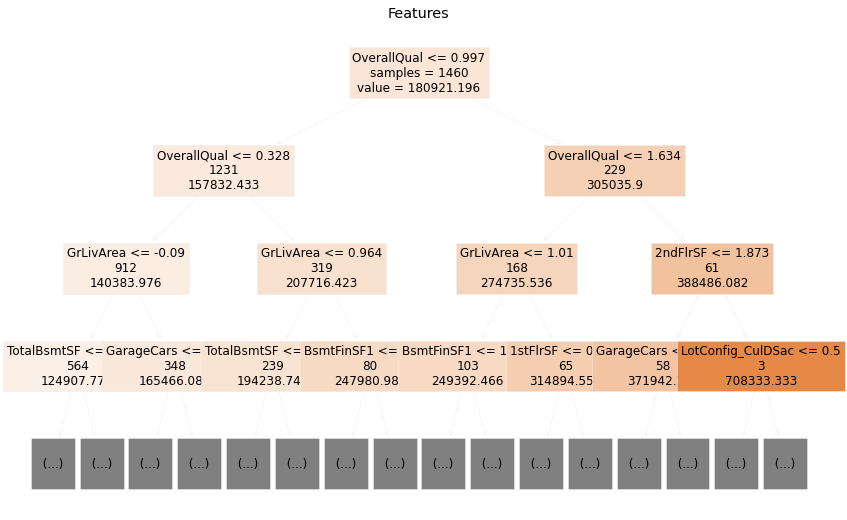

In [14]:
if learning == 'Regression':
    dt = DecisionTreeRegressor()
else:
    dt = DecisionTreeClassifier()
dt.fit(train_X, y)
plt.figure(figsize = (14, 9))
plot_tree(dt, 
          max_depth = 3, 
          filled = True, 
          fontsize=12, 
          label='root', 
          impurity=False, 
          feature_names=train_X.columns
         )
plt.title('Features')
plt.show()

In [15]:
if learning == 'Regression':
    Fstack = RFECV(GradientBoostingRegressor(), 
                 scoring = evaluation)
#     Fstack = RFECV(RidgeCV(), 
#                  scoring = evaluation)
else:
    Fstack = RFECV(MLPClassifier(), 
                 scoring = evaluation)
#     Fstack = RFECV(SVC(), 
#                  scoring = evaluation)

In [16]:
Fstack.fit(train_X, y)

RFECV(estimator=GradientBoostingRegressor(),
      scoring='neg_mean_squared_log_error')

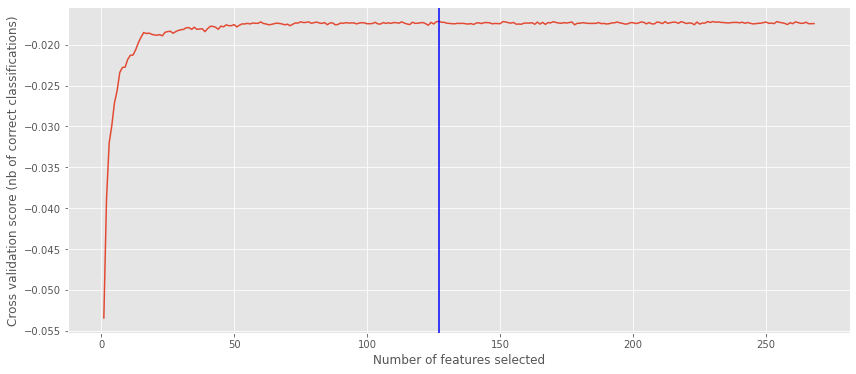

In [17]:
rfescore = Fstack.grid_scores_
plt.figure(figsize=(14, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfescore) + 1), rfescore)
plt.axvline(Fstack.n_features_, color='blue')
# plt.xticks(list(plt.xticks()[0]) + [Fstack.n_features_])
plt.show()

In [18]:
Fstack.n_features_

127

In [19]:
Fstack.grid_scores_.max()

-0.017150470438651373

In [20]:
Fstack.ranking_

array([142,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,  29,   1,   1,   4,   1,   1,
         1,  30,   1,   1,  24,   1,   9,  41,   1,  46,  44,  40,  27,
        58,  59,   1,  55,   1,  48,  66,  70,  51,  75,  73,  49,   1,
         1,  67,   1,  65,   1,   1,  81,   1,   1,   1,   1,   1,   1,
         1,   1,  89, 119,   1,   1,   1,   1,   1,   3,   1, 115, 114,
         1, 117, 124, 125, 122, 131,   1, 133, 110,  10,  12, 134,   1,
        16,  99, 103, 102,   1, 107, 126, 127, 136, 137, 139,   1,   1,
        32,  34,  35,  52,  60,  68,   1,  78,  82,  84,   1,  90,   1,
        94,  96, 104,   1, 141, 135,   1, 123, 113,  15,  50,   1,   1,
        38,  54,  43,  22,  21,   1,  42,   1,  62,  64,  56,  53,  37,
        33,  69,   7,   6,  76,  45,   1,   1,  86,  57,  61,   1,   1,
        71,  13,   1,  17,  47,  83,  85,  80, 106,   1,  14,   

In [21]:
cc = Fstack.get_support()

In [22]:
# cimp = train_X.columns.tolist()
cimp = train_X.columns[cc].tolist()
cimp

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 'YrSold',
 'CentralAir_Y',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RL',
 'MSZoning_RM',
 'LotShape_IR2',
 'LandContour_Bnk',
 'LotConfig_CulDSac',
 'LotConfig_FR3',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighbo

In [23]:
train_csv = train_X[cimp]
test_csv = test_X[cimp]

train_csv[target] = y
test_csv['Id'] = raw_test_data['Id'].tolist()
train_csv['Id'] = raw_train_data['Id'].tolist()

In [24]:
train_csv.to_csv('data\\train.csv', index=False)
test_csv.to_csv('data\\test.csv', index=False)

In [25]:
test_csv.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial,Id
1460,0.553114,0.574141,-0.761451,0.480006,-0.504882,-1.127088,-0.768637,0.322493,2.734501,-0.621490,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1461
1461,0.595321,1.010175,-0.017057,0.480006,-0.592367,-1.220341,0.780093,1.134176,-0.365991,-0.188079,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1462
1462,0.292220,0.945559,-0.761451,-0.453217,0.863747,0.580632,-0.768637,0.935473,-0.365991,-1.099468,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1463
1463,0.467666,0.231909,-0.017057,0.480006,0.910126,0.580632,-0.361421,0.604881,-0.365991,-0.442495,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1464
1464,-1.313362,-1.288756,1.322129,-0.453217,0.637955,0.200395,-0.768637,-0.228298,-0.365991,1.100006,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1465
